In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### Load Data and Add Blockchain Identifier

In [2]:
df_arbitrum = pd.read_csv('arbitrum_clean_data.csv')
df_arbitrum['blockchain'] = 'arbitrum'

df_bsc = pd.read_csv('bsc_clean_data.csv')
df_bsc['blockchain'] = 'bsc'

df_etherium = pd.read_csv('etherium_clean_data.csv')
df_etherium['blockchain'] = 'etherium'

df_fantom = pd.read_csv('fantom_clean_data.csv')
df_fantom['blockchain'] = 'fantom'

df_polygon = pd.read_csv('polygon_clean_data.csv')
df_polygon['blockchain'] = 'polygon'

### Combine DataFrames and Convert Time Columns to Datetime

In [3]:
df = pd.concat([df_arbitrum, df_bsc, df_etherium, df_fantom, df_polygon], ignore_index=True)
print("Combined DataFrame shape:", df.shape)
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

Combined DataFrame shape: (32691, 9)


### Compute Additional Metrics

In [4]:
df['activity_duration'] = (df['end_time'] - df['start_time']).dt.total_seconds()
df['num_transactions'] = df['end_nonce'] - df['start_nonce']
df['num_transactions'] = df['num_transactions'].replace(0, 1)
df['avg_eth_per_tx'] = df['total_eth_sent'] / df['num_transactions']
df['avg_gas_per_tx'] = df['total_gas_utilized_gwei'] / df['num_transactions']
df['tx_per_second'] = df['num_transactions'] / df['activity_duration']

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

### Map Wallet Addresses Across Blockchains

In [5]:
wallet_mapping = df.groupby('wallet_address')['blockchain'].unique().reset_index()
wallet_mapping.rename(columns={'blockchain': 'blockchains_used'}, inplace=True)
wallet_mapping['num_blockchains'] = wallet_mapping['blockchains_used'].apply(len)

print("Wallet mapping (first 10 rows):")
print(wallet_mapping.head(10))
multi_chain_wallets = wallet_mapping[wallet_mapping['num_blockchains'] > 1]
print("Number of wallets used across multiple blockchains:", multi_chain_wallets.shape[0])

Wallet mapping (first 10 rows):
                               wallet_address blockchains_used  \
0  0x0000000000000000000000000000000000000000       [arbitrum]   
1  0x00000000000007736e2f9aa5630b8c812e1f3fc9       [arbitrum]   
2  0x0000000000003e6b8283d286abdbf9a6efa129d0       [arbitrum]   
3  0x0000000009ae004a920069b8e1a189b82403a130       [arbitrum]   
4  0x00000b14af14889bcc3ded2ff9e286d60f424476         [fantom]   
5  0x00000b30b613c18768b179712a0dfd010fb826e7         [fantom]   
6  0x0000102064503bdef8a05b5499b33e6f177aca53         [fantom]   
7  0x0000106626485df70028d00bb08ac2421ee5fb82         [fantom]   
8  0x00001bf6d3fa76977909b7ca3f14ada22cc3ae82         [fantom]   
9  0x00002287bf13b884851e567e936e03cc42eee67b         [fantom]   

   num_blockchains  
0                1  
1                1  
2                1  
3                1  
4                1  
5                1  
6                1  
7                1  
8                1  
9                1  
Number of 

### Analyze User Behavior Patterns and Categorize Users

Cluster statistics:
   cluster  num_transactions  activity_duration  avg_eth_per_tx  \
0        0        850.230074       1.016799e+08      523.211515   
1        1        223.196515       4.085740e+06      137.747322   
2        2        518.476167       4.027102e+07      727.892488   

   avg_gas_per_tx  tx_per_second  
0       27.187400       0.000009  
1       31.303802       0.000808  
2       19.870342       0.000014  


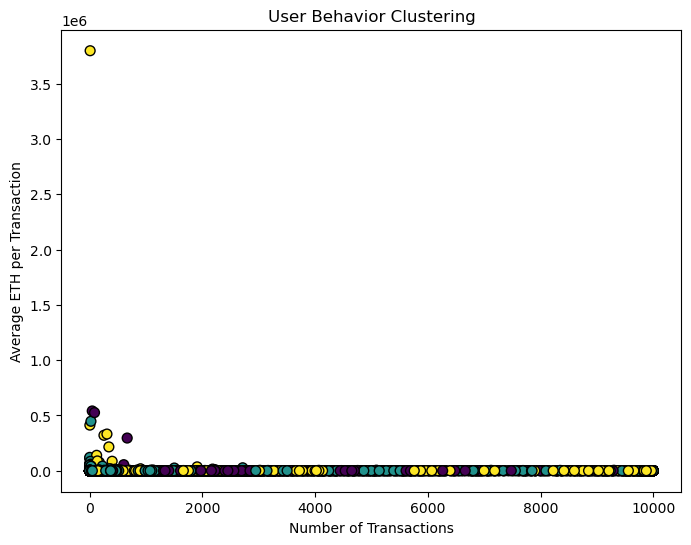

C:\Users\phutb\AppData\Local\Temp\ipykernel_24748\2182984527.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(blockchains))


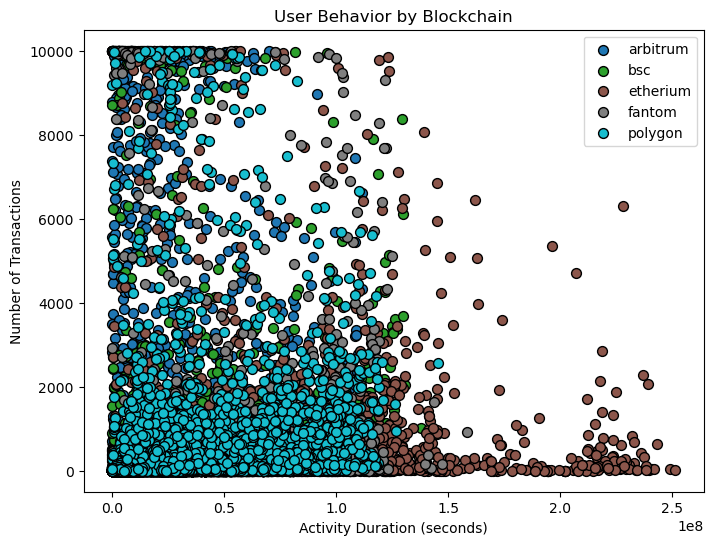

In [6]:
features = df[['num_transactions', 'activity_duration', 'avg_eth_per_tx', 'avg_gas_per_tx', 'tx_per_second']]

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(features)
cluster_stats = df.groupby('cluster').agg({
    'num_transactions': 'mean',
    'activity_duration': 'mean',
    'avg_eth_per_tx': 'mean',
    'avg_gas_per_tx': 'mean',
    'tx_per_second': 'mean'
}).reset_index()
print("Cluster statistics:")
print(cluster_stats)

plt.figure(figsize=(8, 6))
plt.scatter(df['num_transactions'], df['avg_eth_per_tx'], c=df['cluster'], cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Number of Transactions')
plt.ylabel('Average ETH per Transaction')
plt.title('User Behavior Clustering')
plt.show()

plt.figure(figsize=(8, 6))
blockchains = df['blockchain'].unique()
colors = plt.cm.get_cmap('tab10', len(blockchains))

for idx, blockchain in enumerate(blockchains):
    subset = df[df['blockchain'] == blockchain]
    plt.scatter(subset['activity_duration'], subset['num_transactions'], color=colors(idx),
                label=blockchain, edgecolor='k', s=50)

plt.xlabel('Activity Duration (seconds)')
plt.ylabel('Number of Transactions')
plt.title('User Behavior by Blockchain')
plt.legend()
plt.show()

In [7]:
# for save csv
#df.to_csv('enriched_user_behavior.csv', index=False)
#wallet_mapping.to_csv('wallet_mapping.csv', index=False)

# Clustering

Descriptive Statistics by Blockchain:
           tx_count                                                          \
              count        mean          std  min  25%   50%    75%     max   
blockchain                                                                    
arbitrum     5999.0  645.162194  1925.824322  0.0  7.0  21.0  153.0  9998.0   
bsc          6861.0  262.108585   981.745748  0.0  0.0  21.0  134.0  9999.0   
etherium     8655.0  222.796418   926.919693  0.0  1.0  11.0   69.0  9998.0   
fantom       5117.0  320.251710  1240.253564  0.0  0.0   2.0   49.0  9994.0   
polygon      6059.0  401.220829  1237.678870  0.0  0.0  13.0  238.0  9999.0   

           total_eth_sent                 ...                            \
                    count           mean  ...         75%           max   
blockchain                                ...                             
arbitrum           5999.0     377.067352  ...    0.885062  1.094990e+06   
bsc                6861.0    

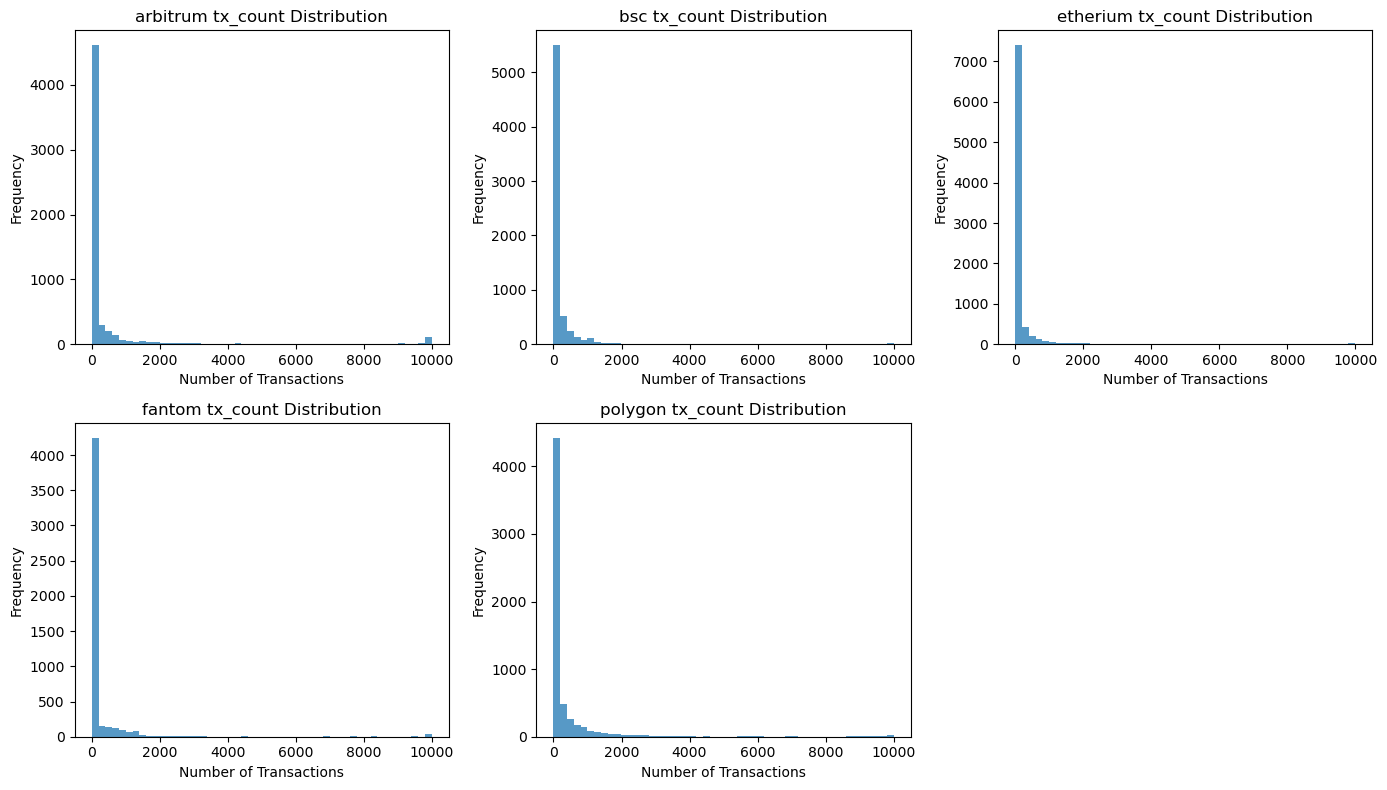

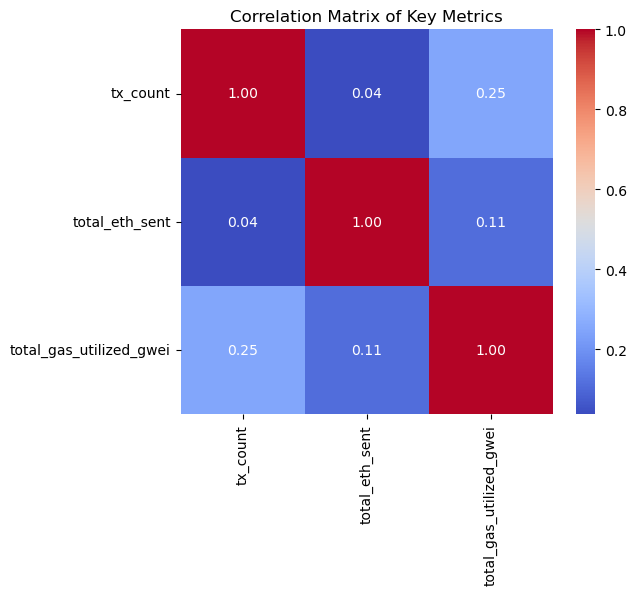


User Category Distribution:
user_category
single-network participant    29410
dormant address                2902
multi-chain user                133
liquidity migrator               40
Name: count, dtype: int64


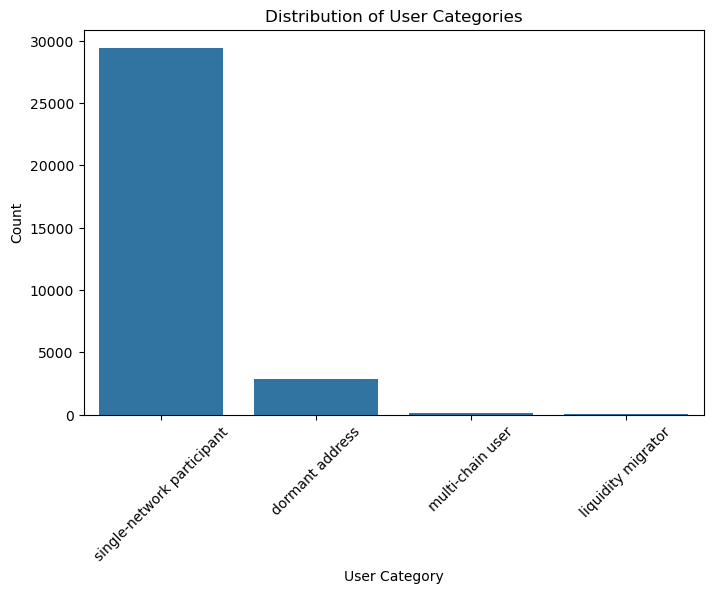


Cluster Distribution:
cluster
2    31717
0      725
1       43
Name: count, dtype: int64


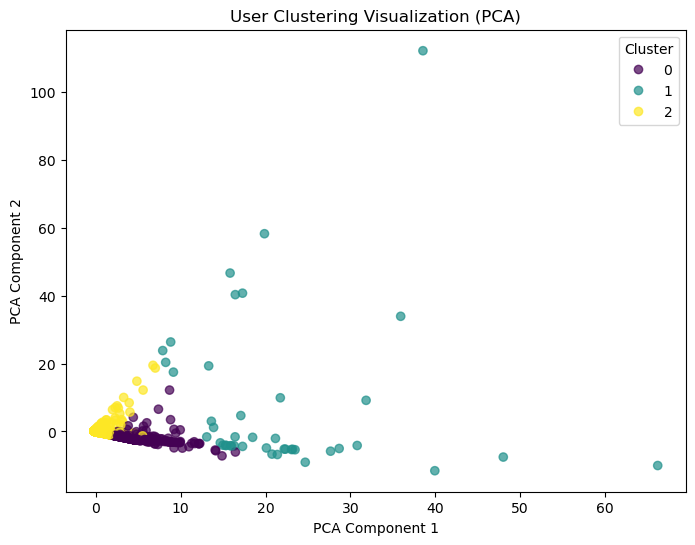

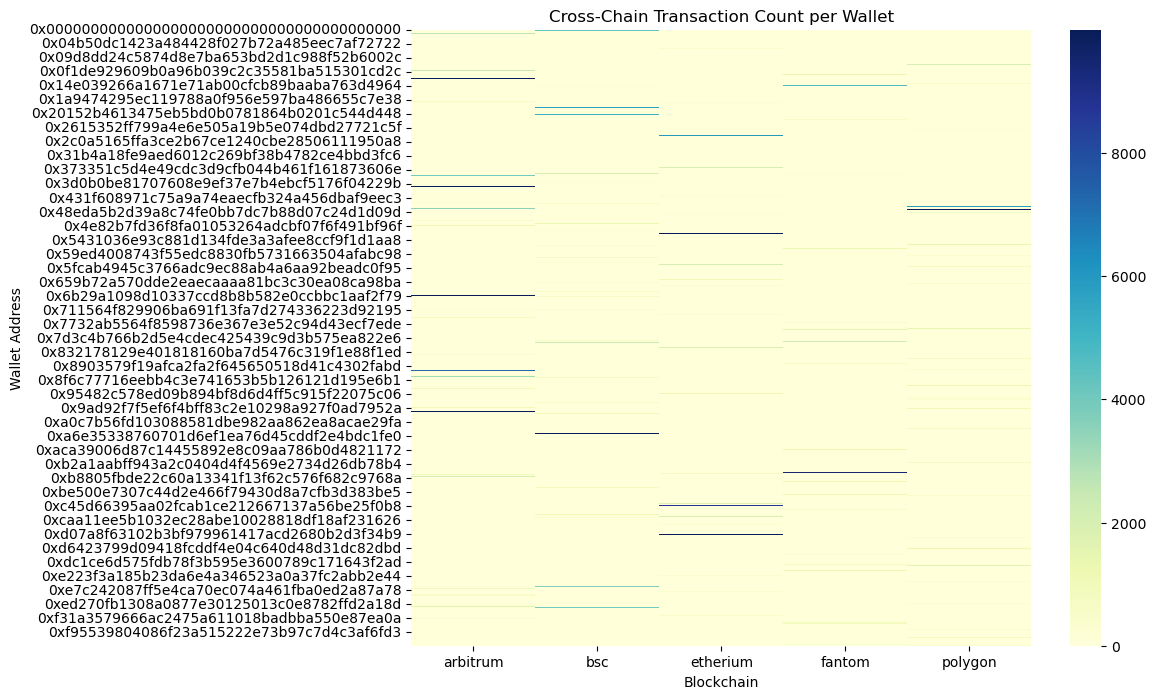

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

df['tx_count'] = df['end_nonce'] - df['start_nonce']

eda_stats = df.groupby('blockchain')[['tx_count', 'total_eth_sent', 'total_gas_utilized_gwei']].describe()
print("Descriptive Statistics by Blockchain:")
print(eda_stats)

unique_chains = df['blockchain'].unique()
plt.figure(figsize=(14, 8))
for i, chain in enumerate(unique_chains, 1):
    plt.subplot(2, 3, i)
    chain_data = df[df['blockchain'] == chain]['tx_count']
    plt.hist(chain_data.dropna(), bins=50, alpha=0.75)
    plt.title(f"{chain} tx_count Distribution")
    plt.xlabel("Number of Transactions")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

corr_matrix = df[['tx_count', 'total_eth_sent', 'total_gas_utilized_gwei']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Key Metrics")
plt.show()


agg_functions = {
    'tx_count': 'sum',
    'total_eth_sent': 'sum',
    'total_gas_utilized_gwei': 'sum',
    'end_time': 'max',               
    'blockchain': pd.Series.nunique  
}

wallet_agg = df.groupby('wallet_address').agg(agg_functions).reset_index()
wallet_agg.rename(columns={'blockchain': 'num_blockchains'}, inplace=True)

dormant_threshold = pd.Timestamp.now() - pd.DateOffset(months=6)

multi_chain_wallets = wallet_agg[wallet_agg['num_blockchains'] > 1]
if not multi_chain_wallets.empty:
    liquidity_threshold = multi_chain_wallets['total_eth_sent'].quantile(0.75)
else:
    liquidity_threshold = 0

def classify_wallet(row):
    """
    Classify a wallet using the following logic:
    - If the latest activity (end_time) is older than 6 months: classify as 'dormant address'
    - Else if the wallet is active in more than one blockchain:
         - If total_eth_sent > liquidity_threshold, classify as 'liquidity migrator'
         - Else, classify as 'multi-chain user'
    - Else if the wallet is active in only one blockchain: classify as 'single-network participant'
    """
    if row['end_time'] < dormant_threshold:
        return 'dormant address'
    elif row['num_blockchains'] > 1:
        if row['total_eth_sent'] > liquidity_threshold:
            return 'liquidity migrator'
        else:
            return 'multi-chain user'
    elif row['num_blockchains'] == 1:
        return 'single-network participant'
    else:
        return 'undefined'

wallet_agg['user_category'] = wallet_agg.apply(classify_wallet, axis=1)

print("\nUser Category Distribution:")
print(wallet_agg['user_category'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x='user_category', data=wallet_agg, order=wallet_agg['user_category'].value_counts().index)
plt.title("Distribution of User Categories")
plt.xlabel("User Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

features = wallet_agg[['tx_count', 'total_eth_sent', 'total_gas_utilized_gwei']].fillna(0)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
wallet_agg['cluster'] = kmeans.fit_predict(features_scaled)

print("\nCluster Distribution:")
print(wallet_agg['cluster'].value_counts())

pca = PCA(n_components=2)
components = pca.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(components[:, 0], components[:, 1], c=wallet_agg['cluster'], cmap='viridis', alpha=0.7)
plt.title("User Clustering Visualization (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

pivot_table = df.pivot_table(index='wallet_address', columns='blockchain', values='tx_count', aggfunc='sum', fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', cbar=True)
plt.title("Cross-Chain Transaction Count per Wallet")
plt.xlabel("Blockchain")
plt.ylabel("Wallet Address")
plt.show()
